設計温度 70.0℃, 設計波長 1.031 um での最適周期:
  SHG周期 (Λ_SHG): 7.2017 um
  SFG周期 (Λ_SFG): 1.9591 um

JITコンパイル中...
コンパイル完了。
計算完了 (カスケード): 0.8264 秒
計算完了 (SHG単独): 0.0456 秒


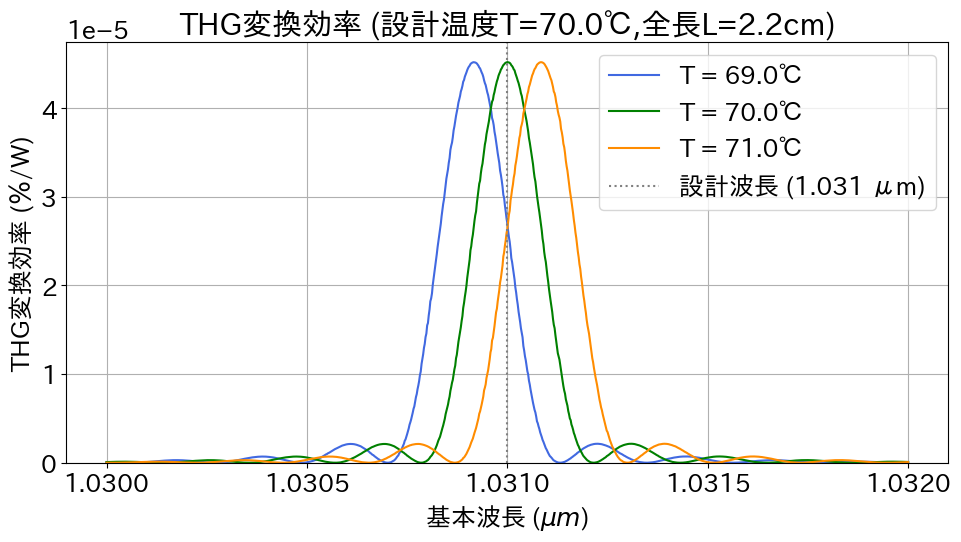

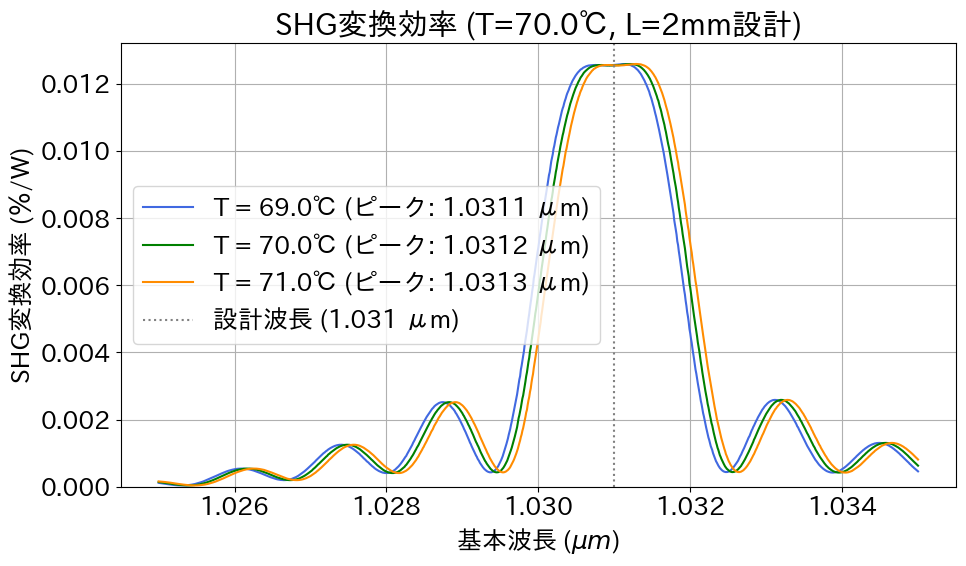

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
from qpm import mgoslt, pp, cwes


# --- 定数設定 ---
Z_SPLIT = 2000.0  # SHGセクションとSFGセクションの境界 (um)
Z_MAX = Z_SPLIT * 2.2    # 結晶の全長 (um)
KAPPA_MAG = 1.31e-5  # 非線形結合係数
DESIGN_TEMP_C = 70.0      # 設計温度 (QPM周期の計算に使用)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (QPM周期の計算に使用)


def simulate_mgoslt_twm(superlattice: jnp.ndarray, temperature: jnp.ndarray, wavelength: jnp.ndarray) -> jnp.ndarray:
    B_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)
    delta_k1 = mgoslt.calc_twm_delta_k(wavelength, wavelength, temperature)
    delta_k2 = mgoslt.calc_twm_delta_k(
        wavelength, wavelength / 2.0, temperature)
    B_final = cwes.simulate_twm(superlattice, delta_k1, delta_k2, B_initial)
    return jnp.abs(B_final[1:3])**2  # FW,SHW,THWなので[1:3]


def run_and_plot():
    """シミュレーションを実行し、結果をプロットする"""
    # パラメータ設定
    wavelengths_narrow = jnp.linspace(1.03, 1.032, 1001)
    wavelengths_wide = jnp.linspace(1.025, 1.035, 1001)
    temperatures = jnp.array([69.0, 70.0, 71.0])

    # 1. 設計条件での位相不整合量を計算
    delta_k_shg_design = mgoslt.calc_twm_delta_k(
        DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
    delta_k_sfg_design = mgoslt.calc_twm_delta_k(
        DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)

    # 2. 最適なQPM周期を逆算
    qpm_period_shg = 2 * jnp.pi / delta_k_shg_design
    qpm_period_sfg = 2 * jnp.pi / delta_k_sfg_design

    print(f"設計温度 {DESIGN_TEMP_C}℃, 設計波長 {DESIGN_WAVELENGTH} um での最適周期:")
    print(f"  SHG周期 (Λ_SHG): {qpm_period_shg:.4f} um")
    print(f"  SFG周期 (Λ_SFG): {qpm_period_sfg:.4f} um")

    # --- 3. QPM格子の各部品を生成 ---
    shg_section_original = pp.generate_section(
        Z_SPLIT, qpm_period_shg, KAPPA_MAG)

    shg_len = Z_SPLIT
    split_len = 0.165 * shg_len
    domain_len_shg = qpm_period_shg / 2.0
    split_idx = jnp.floor(split_len / domain_len_shg).astype(int)

    shg_part1 = shg_section_original[:split_idx]
    shg_part2 = shg_section_original[split_idx:]
    shg_part2_flipped = shg_part2.at[:, 1].set(-shg_part2[:, 1])

    shg_section = jnp.concatenate([shg_part1, shg_part2_flipped], axis=0)
    sfg_section = pp.generate_section(
        Z_MAX - Z_SPLIT, qpm_period_sfg, KAPPA_MAG)
    blank_section = pp.generate_section(Z_MAX - Z_SPLIT, qpm_period_sfg, 0.0)

    # --- 4. 部品を組み合わせて構造を定義し、パディングとスタックを行う ---
    superlattice_cascade = jnp.concatenate([shg_section, sfg_section], axis=0)
    superlattice_shg_only = jnp.concatenate(
        [shg_section, blank_section], axis=0)

    lattices = [superlattice_cascade, superlattice_shg_only]
    max_len = max(l.shape[0] for l in lattices)
    superlattices = jnp.stack([
        jnp.concatenate(
            [l, jnp.zeros((max_len - l.shape[0], 2), dtype=l.dtype)])
        for l in lattices
    ])

    # vmapを用いて計算を並列化
    vmapped_propagate = jit(
        vmap(vmap(vmap(simulate_mgoslt_twm, in_axes=(None, None, 0)),
                  in_axes=(None, 0, None)), in_axes=(0, None, None))
    )

    # --- 5. シミュレーション実行 ---
    print("\nJITコンパイル中...")
    # 一度ダミーデータで実行してコンパイルを完了させる
    vmapped_propagate(superlattices, temperatures,
                      wavelengths_wide).block_until_ready()
    print("コンパイル完了。")

    # カスケード構造のシミュレーション (THG用)
    start_time_cascade = time.time()
    results_cascade = vmapped_propagate(
        superlattices[0:1], temperatures, wavelengths_narrow)
    results_cascade_squeezed = jnp.squeeze(
        results_cascade.block_until_ready(), axis=0)
    # NOTE: ％/Wにするため100倍
    # 結果の形状: (温度, 波長, [SHG効率, THG効率])
    thg_efficiencies = results_cascade_squeezed[:, :, 1] * 100
    print(f"計算完了 (カスケード): {time.time() - start_time_cascade:.4f} 秒")

    # SHG単独構造のシミュレーション
    start_time_shg = time.time()
    results_shg_only = vmapped_propagate(
        superlattices[1:2], temperatures, wavelengths_wide)
    results_shg_squeezed = jnp.squeeze(
        results_shg_only.block_until_ready(), axis=0)
    # NOTE: ％/Wにするため100倍
    # 結果の形状: (温度, 波長, [SHG効率, THG効率])
    shg_efficiencies_wide = results_shg_squeezed[:, :, 0] * 100
    print(f"計算完了 (SHG単独): {time.time() - start_time_shg:.4f} 秒")

    # --- 6. 結果の抽出とプロット ---
    colors = ['royalblue', 'green', 'darkorange']
    plt.rcParams['font.size'] = 18

    # プロット1: THG効率 (狭帯域)
    plt.figure(figsize=(10, 6))
    plt.title(f"THG変換効率 (設計温度T={DESIGN_TEMP_C}℃,全長L=2.2cm)")

    for i, temp in enumerate(temperatures):
        plt.plot(wavelengths_narrow, thg_efficiencies[i],
                 label=f"T = {temp}℃", color=colors[i])

    plt.axvline(x=DESIGN_WAVELENGTH, color='gray', linestyle=':',
                label=f'設計波長 ({DESIGN_WAVELENGTH} μm)')
    plt.xlabel(r"基本波長 ($\mu m$)")
    plt.xticks(jnp.arange(1.03, 1.032, 0.0005))
    plt.ylabel(r"THG変換効率 (％/W)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    # プロット2: SHG効率 (広帯域)
    plt.figure(figsize=(10, 6))
    plt.title(f"SHG変換効率 (T={DESIGN_TEMP_C}℃, L=2mm設計)")

    for i, temp in enumerate(temperatures):
        peak_idx = jnp.argmax(shg_efficiencies_wide[i])
        peak_wl = wavelengths_wide[peak_idx]
        peak_eff = shg_efficiencies_wide[i][peak_idx]
        plt.plot(wavelengths_wide, shg_efficiencies_wide[i],
                 label=f"T = {temp}℃ (ピーク: {peak_wl:.4f} μm)", color=colors[i])

    plt.axvline(x=DESIGN_WAVELENGTH, color='gray', linestyle=':',
                label=f'設計波長 ({DESIGN_WAVELENGTH} μm)')
    plt.xlabel(r"基本波長 ($\mu m$)")
    plt.ylabel(r"SHG変換効率 (％/W)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.show()


if __name__ == '__main__':
    run_and_plot()

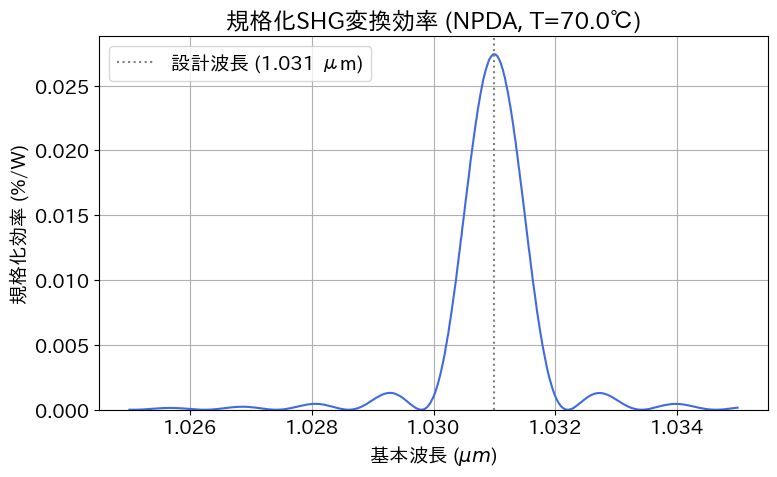

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import japanize_matplotlib
from qpm import mgoslt

# --- 基本設定 ---
L_SHG = 2000.0             # SHG結晶長 (um)
DESIGN_TEMP_C = 70.0       # 設計温度 (℃)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (um)
TARGET_TEMP_C = 70.0       # 計算対象の温度 (℃)

# --- 波長とκ(kappa)の範囲設定 ---
WL_START, WL_END = 1.025, 1.035
KAPPA_START, KAPPA_END = 1.30756e-5, 1.29579e-5

# --- 位相整合条件を計算 ---
# 設計条件での (k_2ω - 2k_ω) が格子ベクトル K_g に対応
K_g = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C
)

# --- スペクトル計算 (JAX配列演算) ---
# 1. 波長配列を生成
wavelengths = jnp.linspace(WL_START, WL_END, 1001)

# 2. 波長に応じて線形に変化するκ(lambda)を計算
kappa = KAPPA_START + (KAPPA_END - KAPPA_START) * \
    (wavelengths - WL_START) / (WL_END - WL_START)

# 3. 全体の位相不整合 Δk を計算
delta_k_material = mgoslt.calc_twm_delta_k(
    wavelengths, wavelengths, TARGET_TEMP_C
)
delta_k_total = delta_k_material - K_g

# 4. ご提示の式に従って規格化効率を計算
# NOTE: NPDAを直接計算すると振幅がπ/2になる、効率はその二乗なので(π/2)^2して補正する、単位が％なのでそれも補正
sinc_squared_part = jnp.sinc(delta_k_total * L_SHG / (2 * jnp.pi))**2
efficiency_norm = (kappa**2) * (L_SHG**2) * \
    sinc_squared_part * 100 * (2 / jnp.pi)**2

# --- プロット ---
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 5))
plt.title(f"規格化SHG変換効率 (NPDA, T={TARGET_TEMP_C}℃)")
plt.plot(wavelengths, efficiency_norm, color='royalblue')
plt.axvline(x=DESIGN_WAVELENGTH, color='gray', linestyle=':',
            label=f'設計波長 ({DESIGN_WAVELENGTH} μm)')
plt.xlabel(r"基本波長 ($\mu m$)")
plt.ylabel(r"規格化効率 (%/W)")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()